# Use of Machine Learning Models for Enthalpy Prediction with GA, GASS, FMF, and SVCF

In [1]:
# import modules and the data set files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# import cleaned raw data
df_ga = pd.read_csv('../GA.csv')
df_gass = pd.read_csv('../GASS.csv')
df_fmf = pd.read_csv('../FMF.csv')
df_svcf = pd.read_csv('../SVCF.csv')

In [3]:
# check if all SMILES in 4 dataframes are in the same order
print((df_ga['SMILES'] == df_gass['SMILES']).mean())
print((df_ga['SMILES'] == df_fmf['SMILES']).mean())
print((df_ga['SMILES'] == df_svcf['SMILES']).mean())

1.0
1.0
1.0


In [4]:
# make output files folders
import os

os.mkdir("Objects")
os.mkdir("Plots")
os.mkdir("Tables")

## Raw and random added feature sets

In [5]:
# extract raw feature sets
X_ga, X_gass, X_fmf, X_svcf = [i.drop(columns=['SMILES', 'H_298K_per_C']).copy() for i in [df_ga, df_gass, df_fmf, df_svcf]]

In [6]:
# add two random vectors to raw feature sets
import sys
sys.path.append('..')

import feature_eng

In [7]:
# extract target property, y, enthalpy per carbon
y = df_ga['H_298K_per_C'].copy()

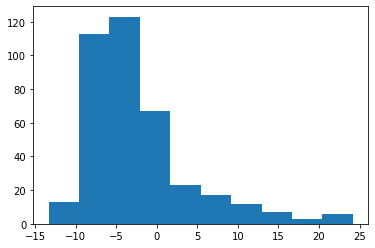

In [8]:
plt.hist(y);

## Five-fold randomly chosen train/test sets

In [9]:
from sklearn.model_selection import KFold

def generate_k_fold_set(X, y, k, seed):
    # make a k-fold object
    kfold = KFold(n_splits=k, shuffle=True, random_state=seed)

    # Create empty lists to store train and test DataFrames
    train_X_sets = []
    train_y_sets = []
    test_X_sets = []
    test_y_sets = []

    # Iterate over the splits and save train/test sets
    for train_index, test_index in kfold.split(X, y):
        train_X_set = X.iloc[train_index]
        train_y_set = y.iloc[train_index]

        test_X_set = X.iloc[test_index]
        test_y_set = y.iloc[test_index]

        train_X_sets.append(train_X_set)
        train_y_sets.append(train_y_set)
        test_X_sets.append(test_X_set)
        test_y_sets.append(test_y_set)

    return train_X_sets, train_y_sets, test_X_sets, test_y_sets


In [10]:
def check_idx(idx_list_to_check, test_list):
    #  two species w/ idx_list_to_check cannot be in the same split set
    for i, split in enumerate(test_list):
        if all(element in split.index.to_list() for element in idx_list_to_check):
            return False
    return True

In [17]:
# check random seed is ok to use
# index 95 and 129 species has G04=1 while all other species have G04=0
# index 18 and 30 species has 1st_C-3rd_C=1 while all other species have 1st_C-3rd_C=0
# index 135 and 153 species has 4th_C-6th_C=1 while all other species have 4th_C-6th_C=0
# these two species will not be together in the same split
rnd_seed=164
X_ga_train_list, y_train_list, X_ga_test_list, y_test_list = generate_k_fold_set(X_ga, y, 5, rnd_seed)
print(check_idx([95,129], y_test_list))
print(check_idx([18,30], y_test_list))
print(check_idx([135,153], y_test_list))

True
True
True


In [18]:
# apply to all raw feature sets
X_ga_train_list, y_train_list, X_ga_test_list, y_test_list = generate_k_fold_set(X_ga, y, 5, rnd_seed)
X_gass_train_list, y_train_list, X_gass_test_list, y_test_list = generate_k_fold_set(X_gass, y, 5, rnd_seed)
X_fmf_train_list, y_train_list, X_fmf_test_list, y_test_list = generate_k_fold_set(X_fmf, y, 5, rnd_seed)
X_svcf_train_list, y_train_list, X_svcf_test_list, y_test_list = generate_k_fold_set(X_svcf, y, 5, rnd_seed)

In [20]:
np.testing.assert_array_equal(X_ga_train_list[3].index, X_fmf_train_list[3].index)
np.testing.assert_array_equal(X_ga_train_list[1].index, y_train_list[1].index)

## Train + Test models

### Train models

In [22]:
# load the fuctions
from ML_regression import build_mlr, build_ridge, build_lasso, build_linear_krr, build_nonlinear_krr, \
    build_linear_svr, build_nonlinear_svr, build_rfr, build_xgb

### 1) Multiple linear regression (MLR)

In [23]:
def train_mlr(feature_train_list, pca=False, n_comp=None):
    if pca == False:
        mlr_1, mlr_2, mlr_3, mlr_4, mlr_5 = [build_mlr().fit(i.to_numpy(), j) for i, j in zip(feature_train_list, y_train_list)]
    
    elif n_comp is not None:
        mlr_1, mlr_2, mlr_3, mlr_4, mlr_5 = [build_mlr(pca=True, n_comp=n_comp).fit(i.to_numpy(), j) for i, j in zip(feature_train_list, y_train_list)]
    
    return mlr_1, mlr_2, mlr_3, mlr_4, mlr_5

#### No PCA

In [24]:
mlr_ga_1, mlr_ga_2, mlr_ga_3, mlr_ga_4, mlr_ga_5 = train_mlr(X_ga_train_list)
mlr_gass_1, mlr_gass_2, mlr_gass_3, mlr_gass_4, mlr_gass_5 = train_mlr(X_gass_train_list)
mlr_fmf_1, mlr_fmf_2, mlr_fmf_3, mlr_fmf_4, mlr_fmf_5 = train_mlr(X_fmf_train_list)
mlr_svcf_1, mlr_svcf_2, mlr_svcf_3, mlr_svcf_4, mlr_svcf_5 = train_mlr(X_svcf_train_list)

#### PCA

In [26]:
# # calculate the number of dimensions for PCA for each feature
# n_ga_pc, n_gass_pc, n_fmf_pc, n_svcf_pc, n_ga_rnd_pc, n_gass_rnd_pc, n_fmf_rnd_pc, n_svcf_rnd_pc \
# = [feature_eng.choose_pca_n(i, 0.95) for i in [X_ga, X_gass, X_fmf, X_svcf, X_ga_rnd, X_gass_rnd, X_fmf_rnd, X_svcf_rnd]]
# print(n_ga_pc, n_gass_pc, n_fmf_pc, n_svcf_pc, n_ga_rnd_pc, n_gass_rnd_pc, n_fmf_rnd_pc, n_svcf_rnd_pc)

In [27]:
# mlr_ga_pc_1, mlr_ga_pc_2, mlr_ga_pc_3, mlr_ga_pc_4, mlr_ga_pc_5 = train_mlr(X_ga_train_list, pca=True, n_comp=6)
# mlr_gass_pc_1, mlr_gass_pc_2, mlr_gass_pc_3, mlr_gass_pc_4, mlr_gass_pc_5 = train_mlr(X_gass_train_list, pca=True, n_comp=9)
# mlr_fmf_pc_1, mlr_fmf_pc_2, mlr_fmf_pc_3, mlr_fmf_pc_4, mlr_fmf_pc_5 = train_mlr(X_fmf_train_list, pca=True, n_comp=6)
# mlr_svcf_pc_1, mlr_svcf_pc_2, mlr_svcf_pc_3, mlr_svcf_pc_4, mlr_svcf_pc_5 = train_mlr(X_svcf_train_list, pca=True, n_comp=7)

### 2) Ridge (RR)

In [29]:
def train_ridge(feature_train_list, pca=False, n_comp=None):
    if pca == False:
        ridge_1, ridge_2, ridge_3, ridge_4, ridge_5 = [build_ridge().fit(i.to_numpy(), j) for i, j in zip(feature_train_list, y_train_list)]
    
    elif n_comp is not None:
        ridge_1, ridge_2, ridge_3, ridge_4, ridge_5 = [build_ridge(pca=True, n_comp=n_comp).fit(i.to_numpy(), j) for i, j in zip(feature_train_list, y_train_list)]
    
    return ridge_1, ridge_2, ridge_3, ridge_4, ridge_5

#### No PCA

In [30]:
ridge_ga_1, ridge_ga_2, ridge_ga_3, ridge_ga_4, ridge_ga_5 = train_ridge(X_ga_train_list)
ridge_gass_1, ridge_gass_2, ridge_gass_3, ridge_gass_4, ridge_gass_5 = train_ridge(X_gass_train_list)
ridge_fmf_1, ridge_fmf_2, ridge_fmf_3, ridge_fmf_4, ridge_fmf_5 = train_ridge(X_fmf_train_list)
ridge_svcf_1, ridge_svcf_2, ridge_svcf_3, ridge_svcf_4, ridge_svcf_5 = train_ridge(X_svcf_train_list)

### 3) LASSO

In [34]:
def train_lasso(feature_train_list, pca=False, n_comp=None):
    if pca == False:
        lasso_1, lasso_2, lasso_3, lasso_4, lasso_5 = [build_lasso().fit(i.to_numpy(), j) for i, j in zip(feature_train_list, y_train_list)]
    
    elif n_comp is not None:
        lasso_1, lasso_2, lasso_3, lasso_4, lasso_5 = [build_lasso(pca=True, n_comp=n_comp).fit(i.to_numpy(), j) for i, j in zip(feature_train_list, y_train_list)]
    
    return lasso_1, lasso_2, lasso_3, lasso_4, lasso_5

#### No PCA

In [35]:
lasso_ga_1, lasso_ga_2, lasso_ga_3, lasso_ga_4, lasso_ga_5 = train_lasso(X_ga_train_list)
lasso_gass_1, lasso_gass_2, lasso_gass_3, lasso_gass_4, lasso_gass_5 = train_lasso(X_gass_train_list)
lasso_fmf_1, lasso_fmf_2, lasso_fmf_3, lasso_fmf_4, lasso_fmf_5 = train_lasso(X_fmf_train_list)
lasso_svcf_1, lasso_svcf_2, lasso_svcf_3, lasso_svcf_4, lasso_svcf_5 = train_lasso(X_svcf_train_list)

### 4) Linear KRR

In [39]:
def train_linear_krr(feature_train_list, pca=False, n_comp=None):
    if pca == False:
        krr_1, krr_2, krr_3, krr_4, krr_5 = [build_linear_krr().fit(i.to_numpy(), j) for i, j in zip(feature_train_list, y_train_list)]
    
    elif n_comp is not None:
        krr_1, krr_2, krr_3, krr_4, krr_5 = [build_linear_krr(pca=True, n_comp=n_comp).fit(i.to_numpy(), j) for i, j in zip(feature_train_list, y_train_list)]
    
    return krr_1, krr_2, krr_3, krr_4, krr_5

### 5) Non-linear KRR

In [42]:
def train_krr(feature_train_list, pca=False, n_comp=None):
    if pca == False:
        krr_1, krr_2, krr_3, krr_4, krr_5 = [build_nonlinear_krr().fit(i.to_numpy(), j) for i, j in zip(feature_train_list, y_train_list)]
    
    elif n_comp is not None:
        krr_1, krr_2, krr_3, krr_4, krr_5 = [build_nonlinear_krr(pca=True, n_comp=n_comp).fit(i.to_numpy(), j) for i, j in zip(feature_train_list, y_train_list)]
    
    return krr_1, krr_2, krr_3, krr_4, krr_5

#### No PCA

In [43]:
krr_ga_1, krr_ga_2, krr_ga_3, krr_ga_4, krr_ga_5 = train_krr(X_ga_train_list)
krr_gass_1, krr_gass_2, krr_gass_3, krr_gass_4, krr_gass_5 = train_krr(X_gass_train_list)
krr_fmf_1, krr_fmf_2, krr_fmf_3, krr_fmf_4, krr_fmf_5 = train_krr(X_fmf_train_list)
krr_svcf_1, krr_svcf_2, krr_svcf_3, krr_svcf_4, krr_svcf_5 = train_krr(X_svcf_train_list)

d:\anaconda3\envs\ml_model\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=4.02708e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
d:\anaconda3\envs\ml_model\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.23104e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
d:\anaconda3\envs\ml_model\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=4.01473e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
d:\anaconda3\envs\ml_model\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.20199e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
d:\anaconda3\envs\ml_model\lib\site-packages\sklearn\linear_mode

d:\anaconda3\envs\ml_model\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.84582e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
d:\anaconda3\envs\ml_model\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.04796e-20): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
d:\anaconda3\envs\ml_model\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.6597e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
d:\anaconda3\envs\ml_model\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.03653e-20): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
d:\anaconda3\envs\ml_model\lib\site-packages\sklearn\linear_model

### 6) Linear SVR

In [47]:
def train_linear_svr(feature_train_list, pca=False, n_comp=None):
    if pca == False:
        svr_1, svr_2, svr_3, svr_4, svr_5 = [build_linear_svr().fit(i.to_numpy(), j) for i, j in zip(feature_train_list, y_train_list)]
    
    elif n_comp is not None:
        svr_1, svr_2, svr_3, svr_4, svr_5 = [build_linear_svr(pca=True, n_comp=n_comp).fit(i.to_numpy(), j) for i, j in zip(feature_train_list, y_train_list)]
    
    return svr_1, svr_2, svr_3, svr_4, svr_5

### 7) Non-linear SVR

In [50]:
def train_svr(feature_train_list, pca=False, n_comp=None):
    if pca == False:
        svr_1, svr_2, svr_3, svr_4, svr_5 = [build_nonlinear_svr().fit(i.to_numpy(), j) for i, j in zip(feature_train_list, y_train_list)]
    
    elif n_comp is not None:
        svr_1, svr_2, svr_3, svr_4, svr_5 = [build_nonlinear_svr(pca=True, n_comp=n_comp).fit(i.to_numpy(), j) for i, j in zip(feature_train_list, y_train_list)]
    
    return svr_1, svr_2, svr_3, svr_4, svr_5

#### No PCA

In [51]:
svr_ga_1, svr_ga_2, svr_ga_3, svr_ga_4, svr_ga_5 = train_svr(X_ga_train_list)
svr_gass_1, svr_gass_2, svr_gass_3, svr_gass_4, svr_gass_5 = train_svr(X_gass_train_list)
svr_fmf_1, svr_fmf_2, svr_fmf_3, svr_fmf_4, svr_fmf_5 = train_svr(X_fmf_train_list)
svr_svcf_1, svr_svcf_2, svr_svcf_3, svr_svcf_4, svr_svcf_5 = train_svr(X_svcf_train_list)

### 8) RFR

In [55]:
def train_rfr(feature_train_list, pca=False, n_comp=None):
    if pca == False:
        rfr_1, rfr_2, rfr_3, rfr_4, rfr_5 = [build_rfr().fit(i.to_numpy(), j) for i, j in zip(feature_train_list, y_train_list)]
    
    elif n_comp is not None:
        rfr_1, rfr_2, rfr_3, rfr_4, rfr_5 = [build_rfr(pca=True, n_comp=n_comp).fit(i.to_numpy(), j) for i, j in zip(feature_train_list, y_train_list)]
    
    return rfr_1, rfr_2, rfr_3, rfr_4, rfr_5

#### No PCA

In [56]:
rfr_ga_1, rfr_ga_2, rfr_ga_3, rfr_ga_4, rfr_ga_5 = train_rfr(X_ga_train_list)
rfr_gass_1, rfr_gass_2, rfr_gass_3, rfr_gass_4, rfr_gass_5 = train_rfr(X_gass_train_list)
rfr_fmf_1, rfr_fmf_2, rfr_fmf_3, rfr_fmf_4, rfr_fmf_5 = train_rfr(X_fmf_train_list)
rfr_svcf_1, rfr_svcf_2, rfr_svcf_3, rfr_svcf_4, rfr_svcf_5 = train_rfr(X_svcf_train_list)

### 9) XGB

In [60]:
def train_xgb(feature_train_list, pca=False, n_comp=None):
    if pca == False:
        xgb_1, xgb_2, xgb_3, xgb_4, xgb_5 = [build_xgb().fit(i.to_numpy(), j) for i, j in zip(feature_train_list, y_train_list)]
    
    elif n_comp is not None:
        xgb_1, xgb_2, xgb_3, xgb_4, xgb_5 = [build_xgb(pca=True, n_comp=n_comp).fit(i.to_numpy(), j) for i, j in zip(feature_train_list, y_train_list)]
    
    return xgb_1, xgb_2, xgb_3, xgb_4, xgb_5

#### No PCA

In [61]:
xgb_ga_1, xgb_ga_2, xgb_ga_3, xgb_ga_4, xgb_ga_5 = train_xgb(X_ga_train_list)
xgb_gass_1, xgb_gass_2, xgb_gass_3, xgb_gass_4, xgb_gass_5 = train_xgb(X_gass_train_list)
xgb_fmf_1, xgb_fmf_2, xgb_fmf_3, xgb_fmf_4, xgb_fmf_5 = train_xgb(X_fmf_train_list)
xgb_svcf_1, xgb_svcf_2, xgb_svcf_3, xgb_svcf_4, xgb_svcf_5 = train_xgb(X_svcf_train_list)

### Save the objects of trained models + train/test X&y lists using pickle

#### Trained models

In [65]:
# make lists for all trained models
# mlr model lists
mlr_ga_list = [mlr_ga_1, mlr_ga_2, mlr_ga_3, mlr_ga_4, mlr_ga_5]
mlr_gass_list = [mlr_gass_1, mlr_gass_2, mlr_gass_3, mlr_gass_4, mlr_gass_5]
mlr_fmf_list = [mlr_fmf_1, mlr_fmf_2, mlr_fmf_3, mlr_fmf_4, mlr_fmf_5]
mlr_svcf_list = [mlr_svcf_1, mlr_svcf_2, mlr_svcf_3, mlr_svcf_4, mlr_svcf_5]

In [66]:
# ridge model lists
ridge_ga_list = [ridge_ga_1, ridge_ga_2, ridge_ga_3, ridge_ga_4, ridge_ga_5]
ridge_gass_list = [ridge_gass_1, ridge_gass_2, ridge_gass_3, ridge_gass_4, ridge_gass_5]
ridge_fmf_list = [ridge_fmf_1, ridge_fmf_2, ridge_fmf_3, ridge_fmf_4, ridge_fmf_5]
ridge_svcf_list = [ridge_svcf_1, ridge_svcf_2, ridge_svcf_3, ridge_svcf_4, ridge_svcf_5]

In [67]:
# lasso model lists
lasso_ga_list = [lasso_ga_1, lasso_ga_2, lasso_ga_3, lasso_ga_4, lasso_ga_5]
lasso_gass_list = [lasso_gass_1, lasso_gass_2, lasso_gass_3, lasso_gass_4, lasso_gass_5]
lasso_fmf_list = [lasso_fmf_1, lasso_fmf_2, lasso_fmf_3, lasso_fmf_4, lasso_fmf_5]
lasso_svcf_list = [lasso_svcf_1, lasso_svcf_2, lasso_svcf_3, lasso_svcf_4, lasso_svcf_5]

In [69]:
# krr model lists
krr_ga_list = [krr_ga_1, krr_ga_2, krr_ga_3, krr_ga_4, krr_ga_5]
krr_gass_list = [krr_gass_1, krr_gass_2, krr_gass_3, krr_gass_4, krr_gass_5]
krr_fmf_list = [krr_fmf_1, krr_fmf_2, krr_fmf_3, krr_fmf_4, krr_fmf_5]
krr_svcf_list = [krr_svcf_1, krr_svcf_2, krr_svcf_3, krr_svcf_4, krr_svcf_5]

In [71]:
# svr model lists
svr_ga_list = [svr_ga_1, svr_ga_2, svr_ga_3, svr_ga_4, svr_ga_5]
svr_gass_list = [svr_gass_1, svr_gass_2, svr_gass_3, svr_gass_4, svr_gass_5]
svr_fmf_list = [svr_fmf_1, svr_fmf_2, svr_fmf_3, svr_fmf_4, svr_fmf_5]
svr_svcf_list = [svr_svcf_1, svr_svcf_2, svr_svcf_3, svr_svcf_4, svr_svcf_5]

In [72]:
# rfr model lists
rfr_ga_list = [rfr_ga_1, rfr_ga_2, rfr_ga_3, rfr_ga_4, rfr_ga_5]
rfr_gass_list = [rfr_gass_1, rfr_gass_2, rfr_gass_3, rfr_gass_4, rfr_gass_5]
rfr_fmf_list = [rfr_fmf_1, rfr_fmf_2, rfr_fmf_3, rfr_fmf_4, rfr_fmf_5]
rfr_svcf_list = [rfr_svcf_1, rfr_svcf_2, rfr_svcf_3, rfr_svcf_4, rfr_svcf_5]

In [73]:
# xgb model lists
xgb_ga_list = [xgb_ga_1, xgb_ga_2, xgb_ga_3, xgb_ga_4, xgb_ga_5]
xgb_gass_list = [xgb_gass_1, xgb_gass_2, xgb_gass_3, xgb_gass_4, xgb_gass_5]
xgb_fmf_list = [xgb_fmf_1, xgb_fmf_2, xgb_fmf_3, xgb_fmf_4, xgb_fmf_5]
xgb_svcf_list = [xgb_svcf_1, xgb_svcf_2, xgb_svcf_3, xgb_svcf_4, xgb_svcf_5]

In [74]:
import pickle

mlr_total_list = [mlr_ga_list,mlr_gass_list,mlr_fmf_list,mlr_svcf_list]
ridge_total_list = [ridge_ga_list,ridge_gass_list,ridge_fmf_list,ridge_svcf_list]
lasso_total_list = [lasso_ga_list,lasso_gass_list,lasso_fmf_list,lasso_svcf_list]
krr_total_list = [krr_ga_list,krr_gass_list,krr_fmf_list,krr_svcf_list]
svr_total_list = [svr_ga_list,svr_gass_list,svr_fmf_list,svr_svcf_list] 
rfr_total_list = [rfr_ga_list,rfr_gass_list,rfr_fmf_list,rfr_svcf_list]
xgb_total_list = [xgb_ga_list,xgb_gass_list,xgb_fmf_list,xgb_svcf_list]

# save all model lists to one file
with open('./Objects/total_model_list.pickle','wb') as f:
    pickle.dump(mlr_total_list, f)
    pickle.dump(ridge_total_list, f)
    pickle.dump(lasso_total_list, f)
    # pickle.dump(linkrr_total_list, f)
    pickle.dump(krr_total_list, f)
    # pickle.dump(linsvr_total_list, f)
    pickle.dump(svr_total_list, f)
    pickle.dump(rfr_total_list, f)
    pickle.dump(xgb_total_list, f)

#### Train/test X & y

In [75]:
total_X_train_list = [X_ga_train_list, X_gass_train_list, X_fmf_train_list, X_svcf_train_list]
total_X_test_list = [X_ga_test_list, X_gass_test_list, X_fmf_test_list, X_svcf_test_list]

# save total X train+test_list to one file
with open('./Objects/total_X_train_test_list.pickle','wb') as f:
    pickle.dump(total_X_train_list, f)
    pickle.dump(total_X_test_list, f)

In [76]:
# save y train+test list to one file
with open('./Objects/total_y_train_test_list.pickle','wb') as f:
    pickle.dump(y_train_list, f)
    pickle.dump(y_test_list, f)

## Export hyperparameters chosen for each model

All best hyperparameters used in the models are exported to csv files

In [77]:
# make a function to make a dataframe displaying the best hyperparameters for each algorithm (all four feature sets x all five splits)

def make_df_total_best_hyperparams(total_model_list):
    best_hyperparams_total_list = []
    for each_feature in total_model_list:
        best_hyperparams_total_list.append([split.best_params_ for split in each_feature])

    labels = ["ga", "gass", "fmf", "svcf"] # Define the corresponding labels

    # Convert the list of dictionaries into a Pandas DataFrame with labels
    dfs_with_labels = []
    for idx, each_feature in enumerate(best_hyperparams_total_list):
        flattened_list = [dict(item, label=labels[idx]) for item in each_feature]
        df = pd.DataFrame(flattened_list)
        dfs_with_labels.append(df)
    
    # Concatenate the dataframes
    df = pd.concat(dfs_with_labels, ignore_index=True)
        
    return df

In [78]:
hyperparams_file_name_list = ['ridge_best_params','lasso_best_params','krr_best_params','svr_best_params','rfr_best_params','xgb_best_params']

for idx,model in enumerate([ridge_total_list,lasso_total_list,krr_total_list,svr_total_list,rfr_total_list,xgb_total_list]):
    make_df_total_best_hyperparams(model).to_csv('Tables/'+hyperparams_file_name_list[idx]+'.csv', index=False)

### Test models

In [79]:
# make dataframes for each fold
df_test_1, df_test_2, df_test_3, df_test_4, df_test_5 = \
    [df_ga.iloc[i.index][['SMILES', 'H_298K_per_C']].copy() for i in X_ga_test_list]

In [80]:
df_model_col_name = ['mlr_ga', 'mlr_gass', 'mlr_fmf', 'mlr_svcf',\
                     'ridge_ga', 'ridge_gass', 'ridge_fmf', 'ridge_svcf',\
                     'lasso_ga', 'lasso_gass', 'lasso_fmf', 'lasso_svcf',\
                     'krr_ga', 'krr_gass', 'krr_fmf', 'krr_svcf',\
                     'svr_ga', 'svr_gass', 'svr_fmf', 'svr_svcf',\
                     'rfr_ga', 'rfr_gass', 'rfr_fmf', 'rfr_svcf',\
                     'xgb_ga', 'xgb_gass', 'xgb_fmf', 'xgb_svcf']

In [81]:
for idx, dataframe in enumerate([df_test_1, df_test_2, df_test_3, df_test_4, df_test_5], start=1):
    for j in df_model_col_name:
        dataframe[j] = np.nan # add columns to each dataframe representing each model
    dataframe['test_split'] = idx # specify the split number for the test species

In [82]:
total_df_test_list = [df_test_1, df_test_2, df_test_3, df_test_4, df_test_5]

In [84]:
# mlr
for i in range(len(total_df_test_list)):
    for j in range(len(mlr_total_list)):
        total_df_test_list[i][df_model_col_name[j]] = mlr_total_list[j][i].predict(total_X_test_list[j][i].to_numpy())

In [85]:
# ridge
for i in range(len(total_df_test_list)):
    for j in range(4):
        total_df_test_list[i][df_model_col_name[j+4]] = ridge_total_list[j][i].predict(total_X_test_list[j][i].to_numpy())

In [86]:
# lasso
for i in range(len(total_df_test_list)):
    for j in range(4):
        total_df_test_list[i][df_model_col_name[j+8]] = lasso_total_list[j][i].predict(total_X_test_list[j][i].to_numpy())

In [88]:
# krr
for i in range(len(total_df_test_list)):
    for j in range(4):
        total_df_test_list[i][df_model_col_name[j+12]] = krr_total_list[j][i].predict(total_X_test_list[j][i].to_numpy())

In [90]:
# svr
for i in range(len(total_df_test_list)):
    for j in range(4):
        total_df_test_list[i][df_model_col_name[j+16]] = svr_total_list[j][i].predict(total_X_test_list[j][i].to_numpy())

In [91]:
# rfr
for i in range(len(total_df_test_list)):
    for j in range(4):
        total_df_test_list[i][df_model_col_name[j+20]] = rfr_total_list[j][i].predict(total_X_test_list[j][i].to_numpy())

In [92]:
# xgb
for i in range(len(total_df_test_list)):
    for j in range(4):
        total_df_test_list[i][df_model_col_name[j+24]] = xgb_total_list[j][i].predict(total_X_test_list[j][i].to_numpy())

In [93]:
# test if the prediction results are correctly saved in dataframes
np.testing.assert_array_equal(lasso_fmf_3.predict(X_fmf_test_list[2].to_numpy()), df_test_3['lasso_fmf'])
np.testing.assert_array_equal(xgb_svcf_5.predict(X_svcf_test_list[4].to_numpy()), df_test_5['xgb_svcf'])
np.testing.assert_array_equal(krr_ga_2.predict(X_ga_test_list[1].to_numpy()), df_test_2['krr_ga'])
np.testing.assert_array_equal(rfr_gass_1.predict(X_gass_test_list[0].to_numpy()), df_test_1['rfr_gass'])

In [94]:
df_test_total = pd.concat([df_test_1, df_test_2, df_test_3, df_test_4, df_test_5]).sort_index().copy()

In [95]:
df_test_total.head()

,SMILES,H_298K_per_C,mlr_ga,mlr_gass,mlr_fmf,mlr_svcf,ridge_ga,ridge_gass,ridge_fmf,ridge_svcf,...,svr_svcf,rfr_ga,rfr_gass,rfr_fmf,rfr_svcf,xgb_ga,xgb_gass,xgb_fmf,xgb_svcf,test_split
0,C([Pt])C,-13.374826,-7.012418,-7.671405,-6.733728,-9.541351,-7.728711,-7.645739,-7.547673,-9.731527,...,-14.164607,-10.770830,-11.014915,-10.431167,-8.089859,-14.206254,-13.837442,-10.592731,-11.423101,3
1,C([Pt])([Pt])C,-8.402182,-4.698689,-4.563866,-4.792674,-7.899915,-4.540330,-5.049545,-5.044199,-8.262257,...,-13.322854,-6.635258,-7.167027,-5.646654,-7.579802,-6.242630,-5.749294,-6.983515,-10.997950,4
2,C(C[Pt])[Pt],-11.576227,-5.574918,-6.921894,-5.999353,-6.713226,-6.482930,-6.889003,-6.861497,-6.992940,...,-10.765318,-7.611698,-8.185128,-9.000160,-7.900257,-9.254578,-8.185720,-9.500269,-11.551361,3
3,C([Pt])([Pt])([Pt])C,-12.636048,-2.420038,-4.227466,-3.737240,-3.608367,-2.456247,-4.177737,-4.175771,-4.667982,...,-4.102462,-1.919436,-5.441152,0.952596,-1.980672,-7.282277,-10.635361,-4.019740,-6.365578,2
4,C(C[Pt])([Pt])[Pt],-6.139024,-4.241996,-4.541185,-4.273092,-8.239031,-4.167950,-4.268719,-4.451260,-8.092832,...,-7.847873,-4.646812,-4.293109,0.099070,-4.170590,-4.120440,-5.358079,-1.829634,-8.046463,5


### Calculate individual errors from df_test_total

In [96]:
# make a dataframe for errors
df_test_errors = df_test_total.copy()
for model in df_test_total.columns[2:-1]:
    df_test_errors[model] = df_test_total[model] - df_test_errors['H_298K_per_C']

df_test_errors.head()

,SMILES,H_298K_per_C,mlr_ga,mlr_gass,mlr_fmf,mlr_svcf,ridge_ga,ridge_gass,ridge_fmf,ridge_svcf,...,svr_svcf,rfr_ga,rfr_gass,rfr_fmf,rfr_svcf,xgb_ga,xgb_gass,xgb_fmf,xgb_svcf,test_split
0,C([Pt])C,-13.374826,6.362408,5.703421,6.641098,3.833475,5.646115,5.729087,5.827154,3.643299,...,-0.789781,2.603996,2.359911,2.943659,5.284967,-0.831428,-0.462616,2.782096,1.951725,3
1,C([Pt])([Pt])C,-8.402182,3.703493,3.838315,3.609508,0.502267,3.861852,3.352637,3.357983,0.139924,...,-4.920672,1.766923,1.235155,2.755528,0.822379,2.159552,2.652887,1.418666,-2.595768,4
2,C(C[Pt])[Pt],-11.576227,6.001308,4.654333,5.576873,4.863001,5.093297,4.687224,4.714730,4.583287,...,0.810908,3.964529,3.391099,2.576067,3.675970,2.321649,3.390506,2.075958,0.024866,3
3,C([Pt])([Pt])([Pt])C,-12.636048,10.216010,8.408583,8.898809,9.027681,10.179801,8.458312,8.460278,7.968067,...,8.533586,10.716612,7.194896,13.588644,10.655376,5.353772,2.000688,8.616309,6.270471,2
4,C(C[Pt])([Pt])[Pt],-6.139024,1.897028,1.597839,1.865932,-2.100007,1.971074,1.870305,1.687764,-1.953808,...,-1.708849,1.492212,1.845915,6.238094,1.968434,2.018584,0.780944,4.309390,-1.907439,5


### Calculate mean and max absolute errors

In [97]:
# mean absolute errors
mean_ae_dict = {}
for model in df_test_total.columns[2:]:
    mean_ae_dict[model] = (abs(df_test_total[model] - df_test_total['H_298K_per_C'])).mean()

df_ae = pd.DataFrame(data=mean_ae_dict, index=['mean'])
df_ae

,mlr_ga,mlr_gass,mlr_fmf,mlr_svcf,ridge_ga,ridge_gass,ridge_fmf,ridge_svcf,lasso_ga,lasso_gass,...,svr_svcf,rfr_ga,rfr_gass,rfr_fmf,rfr_svcf,xgb_ga,xgb_gass,xgb_fmf,xgb_svcf,test_split
mean,1.955054,1.745971,1.913344,2.078183,1.938386,1.747185,1.827285,2.052923,1.940431,1.74467,...,1.657842,1.467263,1.525645,1.462548,1.332446,1.176576,1.257175,1.229807,1.061716,7.721671


In [98]:
# max absolute errors
max_ae_dict = {}
for model in df_test_total.columns[2:]:
    max_ae_dict[model] = (abs(df_test_total[model] - df_test_total['H_298K_per_C'])).max()

df_ae = pd.concat([df_ae, pd.DataFrame(data=max_ae_dict, index=['max'])])

In [99]:
df_ae

,mlr_ga,mlr_gass,mlr_fmf,mlr_svcf,ridge_ga,ridge_gass,ridge_fmf,ridge_svcf,lasso_ga,lasso_gass,...,svr_svcf,rfr_ga,rfr_gass,rfr_fmf,rfr_svcf,xgb_ga,xgb_gass,xgb_fmf,xgb_svcf,test_split
mean,1.955054,1.745971,1.913344,2.078183,1.938386,1.747185,1.827285,2.052923,1.940431,1.744670,...,1.657842,1.467263,1.525645,1.462548,1.332446,1.176576,1.257175,1.229807,1.061716,7.721671
max,16.396706,12.251008,12.409841,14.460035,16.154195,11.893607,12.575455,14.574954,16.103183,11.779852,...,8.533586,10.716612,11.800733,13.588644,10.671432,11.752436,11.884998,10.833192,6.270471,22.240092


### Export prediction results + errors files

In [100]:
# export to csv files
df_test_total.to_csv('384_No_Dicarbon_Predictions.csv', index=False)
df_test_errors.to_csv('384_No_Dicarbon_Errors.csv', index=False)
df_ae.to_csv('384_No_Dicarbon_Mean_Max_AEs.csv')

## Export parity plots to png files

In [101]:
# parity plot
def save_parity_plot(y_test, y_predict, file_name):
    plt.scatter(y_test, y_predict, c='r')
    plt.plot(y_test, y_test, c='b')
    plt.xlabel('DFT Calculated enthalpy (kcal/mol)')
    plt.ylabel('ML Predicted enthalpy (kcal/mol)')
    #plt.show()
    plt.savefig('./Plots/'+file_name)
    plt.close()

In [102]:
# save image files for parity plots
for i in df_test_total.columns[2:-1]:
    save_parity_plot(df_test_total['H_298K_per_C'], df_test_total[i], i+'.png')

## Prediction of enthalpies for All 3115 C2 - C6 species with XGB + GA

In [115]:
# load the data set
df_total_3115_ga = pd.read_csv('../Total_3115_GA.csv')
df_total_3115_ga.head()

,SMILES,G01,G02,G03,G04,T01,T02,T03,B01,B02,H01,label
0,C([Pt])C,1,0,0,0,1,0,0,0,0,0,FC
1,C([Pt])([Pt])C,1,0,0,0,0,0,0,1,0,0,FC
2,C(C[Pt])[Pt],0,0,0,0,2,0,0,0,0,0,FC
3,C([Pt])([Pt])([Pt])C,1,0,0,0,0,0,0,0,0,1,FC
4,C(C[Pt])([Pt])[Pt],0,0,0,0,1,0,0,1,0,0,FC


In [116]:
df_total_3115_ga.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3115 entries, 0 to 3114
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  3115 non-null   object
 1   G01     3115 non-null   int64 
 2   G02     3115 non-null   int64 
 3   G03     3115 non-null   int64 
 4   G04     3115 non-null   int64 
 5   T01     3115 non-null   int64 
 6   T02     3115 non-null   int64 
 7   T03     3115 non-null   int64 
 8   B01     3115 non-null   int64 
 9   B02     3115 non-null   int64 
 10  H01     3115 non-null   int64 
 11  label   3115 non-null   object
dtypes: int64(10), object(2)
memory usage: 292.2+ KB


In [117]:
# add "Cyclic" column
df_total_3115_ga.insert(11,'Cyclic',0)
df_total_3115_ga.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3115 entries, 0 to 3114
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  3115 non-null   object
 1   G01     3115 non-null   int64 
 2   G02     3115 non-null   int64 
 3   G03     3115 non-null   int64 
 4   G04     3115 non-null   int64 
 5   T01     3115 non-null   int64 
 6   T02     3115 non-null   int64 
 7   T03     3115 non-null   int64 
 8   B01     3115 non-null   int64 
 9   B02     3115 non-null   int64 
 10  H01     3115 non-null   int64 
 11  Cyclic  3115 non-null   int64 
 12  label   3115 non-null   object
dtypes: int64(11), object(2)
memory usage: 316.5+ KB


In [118]:
# add # of C and H
df_total_3115_ga['C_num'] = df_total_3115_ga.iloc[:,1:11].sum(axis=1)
df_total_3115_ga['H_num'] = (df_total_3115_ga['C_num']*2 + 2) - df_total_3115_ga.SMILES.str.count("Pt")

In [119]:
# add x-axis values
df_total_3115_ga['x_val'] = df_total_3115_ga['C_num'] + 0.05*df_total_3115_ga['H_num']
df_total_3115_ga

,SMILES,G01,G02,G03,G04,T01,T02,T03,B01,B02,H01,Cyclic,label,C_num,H_num,x_val
0,C([Pt])C,1,0,0,0,1,0,0,0,0,0,0,FC,2,5,2.25
1,C([Pt])([Pt])C,1,0,0,0,0,0,0,1,0,0,0,FC,2,4,2.20
2,C(C[Pt])[Pt],0,0,0,0,2,0,0,0,0,0,0,FC,2,4,2.20
3,C([Pt])([Pt])([Pt])C,1,0,0,0,0,0,0,0,0,1,0,FC,2,3,2.15
4,C(C[Pt])([Pt])[Pt],0,0,0,0,1,0,0,1,0,0,0,FC,2,3,2.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3110,C(C(C([Pt])([Pt])[Pt])(C([Pt])([Pt])[Pt])C([Pt...,0,0,0,1,0,0,0,0,0,4,0,OTHER,5,0,5.00
3111,C(C(C([Pt])([Pt])[Pt])(C([Pt])([Pt])[Pt])C(C([...,0,0,0,1,0,1,0,1,0,3,0,OTHER,6,2,6.10
3112,C(C(C(C([Pt])([Pt])[Pt])(C([Pt])([Pt])[Pt])C([...,0,0,0,1,0,1,0,0,0,4,0,OTHER,6,1,6.05
3113,C(C(C([Pt])([Pt])[Pt])(C([Pt])([Pt])[Pt])C(C([...,0,0,0,1,0,0,0,1,1,3,0,OTHER,6,1,6.05


In [120]:
# prediction of enthalpies
# extract features
X_total_3115_ga = df_total_3115_ga.iloc[:,1:12]
X_total_3115_ga

,G01,G02,G03,G04,T01,T02,T03,B01,B02,H01,Cyclic
0,1,0,0,0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,2,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3110,0,0,0,1,0,0,0,0,0,4,0
3111,0,0,0,1,0,1,0,1,0,3,0
3112,0,0,0,1,0,1,0,0,0,4,0
3113,0,0,0,1,0,0,0,1,1,3,0


In [121]:
df_total_3115_pred = df_total_3115_ga[['SMILES','x_val']].copy()
df_total_3115_pred['krr_ga'] = np.nan
df_total_3115_pred['xgb_ga'] = np.nan
df_total_3115_pred.head()

,SMILES,x_val,krr_ga,xgb_ga
0,C([Pt])C,2.25,NaN,NaN
1,C([Pt])([Pt])C,2.20,NaN,NaN
2,C(C[Pt])[Pt],2.20,NaN,NaN
3,C([Pt])([Pt])([Pt])C,2.15,NaN,NaN
4,C(C[Pt])([Pt])[Pt],2.15,NaN,NaN


In [122]:
# prediction with krr models
krr_total_3115_pred_list = [i.predict(X_total_3115_ga.to_numpy()) for i in krr_ga_list]

def sum_list(l):
    sum = 0
    for x in l:
        sum += x
    return sum

df_total_3115_pred['krr_ga'] = sum_list(krr_total_3115_pred_list) / 5

In [123]:
# prediction with xgb models
xgb_total_3115_pred_list = [i.predict(X_total_3115_ga.to_numpy()) for i in xgb_ga_list]
df_total_3115_pred['xgb_ga'] = sum_list(xgb_total_3115_pred_list) / 5

In [124]:
# ensemble
df_total_3115_pred['krr_xgb_ensemble_per_carbon'] = df_total_3115_pred[['krr_ga', 'xgb_ga']].mean(axis=1)

In [125]:
df_total_3115_pred['krr_xgb_ensemble_raw_H'] = df_total_3115_pred['krr_xgb_ensemble_per_carbon'] * df_total_3115_ga['C_num']

In [126]:
df_total_3115_pred

,SMILES,x_val,krr_ga,xgb_ga,krr_xgb_ensemble_per_carbon,krr_xgb_ensemble_raw_H
0,C([Pt])C,2.25,-13.574350,-13.780685,-13.677518,-27.355036
1,C([Pt])([Pt])C,2.20,-8.456198,-7.579658,-8.017928,-16.035855
2,C(C[Pt])[Pt],2.20,-10.606636,-10.346762,-10.476699,-20.953398
3,C([Pt])([Pt])([Pt])C,2.15,-6.491002,-9.420813,-7.955907,-15.911814
4,C(C[Pt])([Pt])[Pt],2.15,-5.167086,-5.353100,-5.260093,-10.520185
...,...,...,...,...,...,...
3110,C(C(C([Pt])([Pt])[Pt])(C([Pt])([Pt])[Pt])C([Pt...,5.00,45.251702,19.504980,32.378341,161.891705
3111,C(C(C([Pt])([Pt])[Pt])(C([Pt])([Pt])[Pt])C(C([...,6.10,27.920109,10.308996,19.114553,114.687315
3112,C(C(C(C([Pt])([Pt])[Pt])(C([Pt])([Pt])[Pt])C([...,6.05,33.880515,11.243666,22.562091,135.372543
3113,C(C(C([Pt])([Pt])[Pt])(C([Pt])([Pt])[Pt])C(C([...,6.05,40.161372,21.738829,30.950101,185.700603


In [127]:
df_total_3115_pred['x_val'].describe()

count    3115.000000
mean        6.058652
std         0.646433
min         2.000000
25%         6.150000
50%         6.300000
75%         6.400000
max         6.650000
Name: x_val, dtype: float64

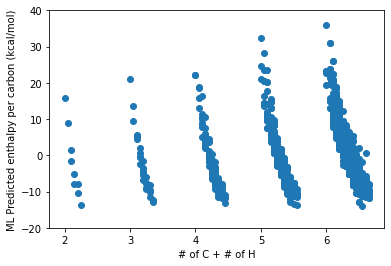

In [128]:
# scatter plots (PER carbon)
plt.scatter(df_total_3115_pred['x_val'], df_total_3115_pred['krr_xgb_ensemble_per_carbon'])
plt.xlabel('# of C + # of H')
plt.ylabel('ML Predicted enthalpy per carbon (kcal/mol)')
plt.ylim([-20,40]);

(-100.0, 250.0)

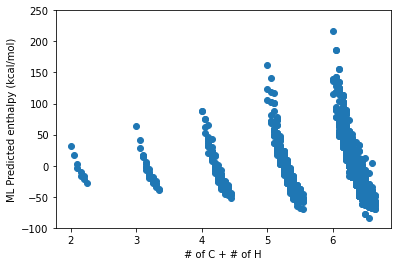

In [129]:
# scatter plots (raw or total enthalpy)
plt.scatter(df_total_3115_pred['x_val'], df_total_3115_pred['krr_xgb_ensemble_raw_H'])
plt.xlabel('# of C + # of H')
plt.ylabel('ML Predicted enthalpy (kcal/mol)')
plt.ylim([-100,250])

In [130]:
np.sort(df_total_3115_pred['x_val'].unique())

array([2.  , 2.05, 2.1 , 2.15, 2.2 , 2.25, 3.  , 3.05, 3.1 , 3.15, 3.2 ,
       3.25, 3.3 , 3.35, 4.  , 4.05, 4.1 , 4.15, 4.2 , 4.25, 4.3 , 4.35,
       4.4 , 4.45, 5.  , 5.05, 5.1 , 5.15, 5.2 , 5.25, 5.3 , 5.35, 5.4 ,
       5.45, 5.5 , 5.55, 6.  , 6.05, 6.1 , 6.15, 6.2 , 6.25, 6.3 , 6.35,
       6.4 , 6.45, 6.5 , 6.55, 6.6 , 6.65])

In [131]:
df_total_3115_pred.query('x_val >= 6.00').groupby(['x_val'])['SMILES'].count()

x_val
6.00      5
6.05     17
6.10     52
6.15    109
6.20    198
6.25    287
6.30    367
6.35    390
6.40    367
6.45    287
6.50    198
6.55    109
6.60     52
6.65     17
Name: SMILES, dtype: int64

In [132]:
df_total_3115_pred.query('x_val >= 2.00 and x_val < 3')['krr_xgb_ensemble_raw_H'].describe()

count     9.000000
mean     -4.587535
std      19.264496
min     -27.355036
25%     -16.035855
50%     -10.520185
75%       3.181398
max      31.861879
Name: krr_xgb_ensemble_raw_H, dtype: float64

In [133]:
df_total_3115_pred.query('x_val >= 6.00')['krr_xgb_ensemble_raw_H'].describe()

count    2455.000000
mean       -3.470530
std        36.669159
min       -84.083441
25%       -29.006081
50%       -10.438317
75%        14.578239
max       216.129068
Name: krr_xgb_ensemble_raw_H, dtype: float64

In [134]:
df_total_3115_pred.query('x_val >= 2.00 and x_val < 3')['krr_xgb_ensemble_per_carbon'].describe()

count     9.000000
mean     -2.293768
std       9.632248
min     -13.677518
25%      -8.017928
50%      -5.260093
75%       1.590699
max      15.930939
Name: krr_xgb_ensemble_per_carbon, dtype: float64

In [135]:
df_total_3115_pred.query('x_val >= 6.00')['krr_xgb_ensemble_per_carbon'].describe()

count    2455.000000
mean       -0.578422
std         6.111527
min       -14.013907
25%        -4.834347
50%        -1.739719
75%         2.429707
max        36.021511
Name: krr_xgb_ensemble_per_carbon, dtype: float64

In [136]:
df_total_3115_pred.query('x_val == 6.35').sort_values(by='krr_xgb_ensemble_raw_H').head(30)

,SMILES,x_val,krr_ga,xgb_ga,krr_xgb_ensemble_per_carbon,krr_xgb_ensemble_raw_H
1118,C(CC(C[Pt])CC([Pt])([Pt])[Pt])([Pt])([Pt])[Pt],6.35,-6.150744,-4.370633,-5.260688,-31.564130
2265,C(CC(C([Pt])([Pt])[Pt])CC[Pt])([Pt])([Pt])[Pt],6.35,-6.150744,-4.370633,-5.260688,-31.564130
1506,C(CCC(C([Pt])([Pt])[Pt])C[Pt])([Pt])([Pt])[Pt],6.35,-6.150744,-4.370633,-5.260688,-31.564130
2262,C(C(C([Pt])([Pt])[Pt])CCC[Pt])([Pt])([Pt])[Pt],6.35,-6.150744,-4.370633,-5.260688,-31.564130
2387,C(C(C([Pt])([Pt])[Pt])C(C[Pt])C)([Pt])([Pt])[Pt],6.35,-14.320325,4.098130,-5.111097,-30.666583
1525,C(C(C(C([Pt])([Pt])[Pt])C)C[Pt])([Pt])([Pt])[Pt],6.35,-14.320325,4.098130,-5.111097,-30.666583
1933,C(C(C(C(C([Pt])C)[Pt])[Pt])[Pt])([Pt])([Pt])[Pt],6.35,-4.158176,-5.573709,-4.865942,-29.195652
804,C(C(C(C(C[Pt])[Pt])C[Pt])[Pt])([Pt])([Pt])[Pt],6.35,-6.282048,-3.386646,-4.834347,-29.006081
2366,C(C(C(C[Pt])[Pt])C(C[Pt])[Pt])([Pt])([Pt])[Pt],6.35,-6.282048,-3.386646,-4.834347,-29.006081
2138,C(C(C(C(C[Pt])C[Pt])[Pt])[Pt])([Pt])([Pt])[Pt],6.35,-6.282048,-3.386646,-4.834347,-29.006081


In [137]:
df_total_3115_pred.query('x_val == 6.35')['krr_xgb_ensemble_raw_H'].describe()

count    390.000000
mean      -9.734319
std       11.399299
min      -31.564130
25%      -16.992455
50%      -10.826595
75%       -4.813043
max       38.640512
Name: krr_xgb_ensemble_raw_H, dtype: float64

In [138]:
# extract predictino of 3115 species to a csv file
df_total_3115_pred.to_csv('C2_C6_3115_Predictions.csv')